## Viewing the surface temperature of a city 🌡️🛰️🏙️

#### Goal: 
to create a gif that displays the land surface temperature (LST) for a selected part of a city, alongside an optical image obtained within the same time frame

#### Data:
- ECOSTRESS surface temperature (product: ECO2LSTE.001)
- ECOSTRESS surface temperature statistics 
- ECOSTRESS cloud mask (product: ECO2CLD.001)
- ECOSTRESS cloud mask lookup
- Sentinel-2 L1C image 

#### Example area & time: 
Bialystok's (Poland) city, year of 2022

#### Processing steps:
1. selecting the area and time to be analyzed   
2. downloading Sentinel-2 data using API
3. downloading ECOSTRESS data using API
4. transforming the data to a common coordinate system
5. stacking and clipping the data to a common spatial extent
6. calculating the Surface Temperature 
7. familiarizing with the LST statistics
8. converting cloud raster masks into polygon features
9. creating an animated gif

#### Sources:
- geojson drawing page: https://geojson.io/
- ECOSTRESS page: https://ecostress.jpl.nasa.gov/
- ECOSTRESS API: https://appeears.earthdatacloud.nasa.gov/api/?python#introduction
- Creodias platform: https://creodias.eu/

Prepared by: Aleksandra Radecka <br/>
e-mail: aleksandraradecka@protonmail.com

### Step 0: importing packages

In [1]:
import os
import glob
import json
import shutil
import zipfile
import requests
import rasterio
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
import geopandas as gpd
import earthpy.plot as ep
from matplotlib import pyplot
from sentinelsat.sentinel import read_geojson, geojson_to_wkt

### Step 1: selecting the area and time to be analyzed
As the first step, we need to define the spatial extent of our research area. It can achieved i.a. by providing a vector layer created in a GIS software or online on geojson.io. I chose the second option - by drawing a geometry, I created a polygon layer and downloaded it in a form of a GeoJSON file. We can see it here:

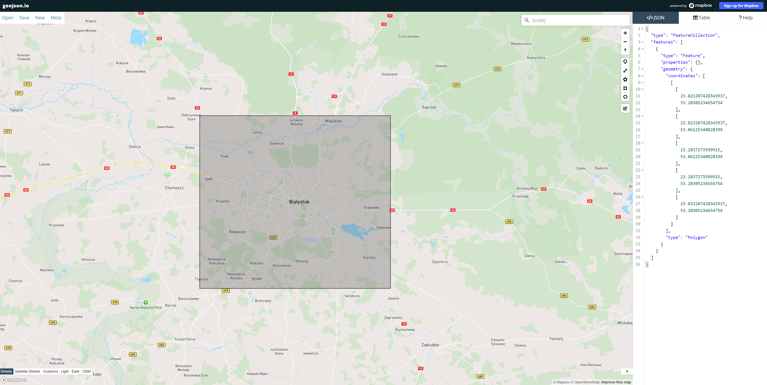

In [2]:
image = Image.open('bialystok_geojsonio.png')
display(image.resize((int(image.width * 0.2), int(image.height * 0.2))))

Let's now define the two necessary variables that will be used throughout the processing workflow:

In [3]:
area_path = 'map.geojson'

In [4]:
start_date = '2022-01-01'
end_date = '2022-12-31'

### Step 2: downloading Sentinel-2 data using API

As the next step, we should find and download a Sentinel-2 optical image which will serve as a supplementary material in the future gif file. We will present it alongside the temperature image to ease the visual analysis. The Sentinel-2 image should fulfil a few important criteria: be covering the area of our research, be acquired in the analysed time frame and preferably be cloud free.

Sentinel-2 data are distributed by many different providers. I will take advantage of the Creodias cloud-based platform - one of European Data and Information Access Services (DIASes). 

In [5]:
# geojson to wkt transform
aoi = geojson_to_wkt(read_geojson(area_path)) 

In [6]:
search_dict = {
    "maxRecords": 100,
    "page": 1,
    "startDate": start_date,
    "completionDate": end_date,
    "geometry": aoi,
    "cloudCover": '[0,5]', 
    "productType": 'S2MSI1C', 
    "sortParam": 'cloudCover', 
    "sortOrder": 'ascending'
}

In [7]:
endpoint = "http://finder.creodias.eu/resto/api/collections/Sentinel2/search.json?"

In [8]:
response = requests.get(endpoint, params = search_dict) 

In [9]:
response_json = response.json()

In [10]:
# creating a vector file containing both spatial extent and attributes of the images found 
with open('s2_city.geojson', 'wb') as fd:
    for chunk in response.iter_content(chunk_size=128):
        fd.write(chunk)

In [11]:
response_gdf = gpd.read_file('s2_city.geojson')

In [12]:
response_gdf.loc[:, ["collection", "startDate", "processingLevel", "platform", "cloudCover"]] 

,collection,startDate,processingLevel,platform,cloudCover
0,SENTINEL-2,2022-03-22T09:30:29.024000+00:00,S2MSI1C,S2B,0.000000
1,SENTINEL-2,2022-03-15T09:40:29.024000+00:00,S2MSI1C,S2B,0.000000
2,SENTINEL-2,2022-03-22T09:30:29.024000+00:00,S2MSI1C,S2B,0.000000
3,SENTINEL-2,2022-03-20T09:40:31.024000+00:00,S2MSI1C,S2A,0.000000
4,SENTINEL-2,2022-03-20T09:40:31.024000+00:00,S2MSI1C,S2A,0.000000
5,SENTINEL-2,2022-02-28T09:40:31.024000+00:00,S2MSI1C,S2A,0.000000
6,SENTINEL-2,2022-02-28T09:40:31.024000+00:00,S2MSI1C,S2A,0.000000
7,SENTINEL-2,2022-03-15T09:40:29.024000+00:00,S2MSI1C,S2B,0.037326
8,SENTINEL-2,2022-03-17T09:30:41.023998+00:00,S2MSI1C,S2A,0.052601
9,SENTINEL-2,2022-03-25T09:40:29.024000+00:00,S2MSI1C,S2B,0.177013


We can observe that 20 images fulfil our criteria. As the first seven images all have 0% of cloud coverge, any of them will most probably be a very good choice. We should however check two other aspects - if the image fully covers our selected area of research (the current functionality of the API do not allow to do this automatically) and if the image's acquisition took place in a phenologically favourable time. 

For these reasons I inspected the prepared `s2_city.geojson` file visually in my GIS software. Alternatively, one could also present this layer here in Jupyter Notebook using `ipyleaflet` widget. Another, more automatized way would be to intersect the `s2_city.geojson` and `map.geojson` layers and perform a quick analysis aimed at finding a non-cloudy image which fully covers the research area.

A link to the selected product is included in the server's response file:

In [24]:
zipper_link = response_json['features'][11]['properties']['services']['download']['url']

As well as the title:

In [25]:
title = response_json['features'][11]['properties']['title']

In [26]:
print(zipper_link, title)

https://zipper.creodias.eu/download/afe7ea46-8524-5f83-8c47-59e763ddf3f4 S2B_MSIL1C_20220504T094029_N0400_R036_T34UFD_20220504T114559.SAFE


In order to access the file we need to create the account on the Creodias platform. Having it, we are able to generate a token using our username and password:

In [16]:
username_dias = 'aleksandra.radecka@pw.edu.pl'
password_dias = 'xxx'

In [17]:
# (function created by the Creodias Team)
def get_keycloak_token(username, password):
    h = {
    'Content-Type': 'application/x-www-form-urlencoded'
    }
    d = {
    'client_id': 'CLOUDFERRO_PUBLIC',
    'password': password_dias,
    'username': username_dias,
    'grant_type': 'password'
    }
    resp = requests.post('https://auth.creodias.eu/auth/realms/dias/protocol/openid-connect/token', data=d, headers=h)
    # print(resp.status_code)
    try:
        token = json.loads(resp.content.decode('utf-8'))['access_token']
    except KeyError:
        print("Can't obtain a token (check username/password), exiting.")
        sys.exit()
    # print(token)
    return token

In [27]:
# generating token
token_dias = get_keycloak_token(username = username_dias, password = password_dias)

In [28]:
# creating a query
query_d = zipper_link + "?token=" + token_dias

In [29]:
# sending a request
response_d = requests.get(query_d, stream = True)

In [30]:
# downloading the SAFE file
with open(title, 'wb') as out_file:
    shutil.copyfileobj(response_d.raw, out_file)

In [31]:
# extracting the contents to a new folder
with zipfile.ZipFile(title, 'r') as zip_ref:
    zip_ref.extractall('s2')

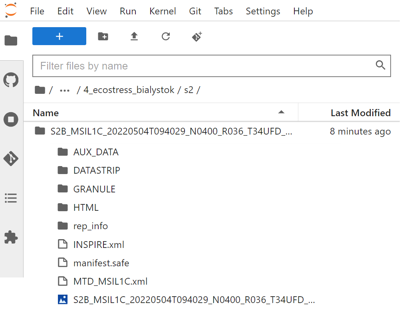

In [32]:
image = Image.open('s2_files.png')
display(image.resize((int(image.width * 0.4), int(image.height * 0.4))))

We can also have a look at the quicklook file provided in the downloaded product:

In [33]:
quicklook_path = 's2/S2B_MSIL1C_20220504T094029_N0400_R036_T34UFD_20220504T114559.SAFE/S2B_MSIL1C_20220504T094029_N0400_R036_T34UFD_20220504T114559-ql.jpg'

In [34]:
quicklook = Image.open(quicklook_path)

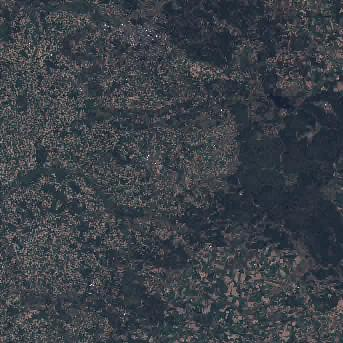

In [35]:
display(quicklook)

Bialystok is located in the northern part of the image and as expected is fortunately cloud free. The choice of May allows to see the vegetation clearly. 

### Step 3. downloading ECOSTRESS data using API

The ECOSTRESS data can be downloaded in a similar way, using the NASA's Application for Extracting and Exploring Analysis Ready Samples (AρρEEARS) platform. We will use the same spatial extent and time frame. Even though the cloud coverage of thermal data is as important (for land analysis) as it was for optical images, this criterion will not be evaluated now. The request to API results in images being clipped to the research area that was provided. The cloud coverage assessment made after the clipping process will be more accurate, as it will refer to the smaller area, not the entire scene. 

As the first step, we need to authenticate our AρρEEARS account by providing the username and the password. It will enable us to generate the token:

In [36]:
response_eco = requests.post('https://appeears.earthdatacloud.nasa.gov/api/login', auth=('aleksandra_radecka1', 'xxx'))

In [37]:
token_response_eco = response_eco.json()

In [38]:
token_response_eco

{'token_type': 'Bearer',
 'token': 'AoAiYS2F1FjuV4o1jBTCTnyAEuKWbutEFPZIjDZl9pfrNm4J_xcA958kaO9bEWacUyB4R0TPYqahqy0mZFLzyQ',
 'expiration': '2023-03-26T08:52:49Z'}

Next, we will create a list of geographic coordinates of the corners of the research area polygon. The list will then be used in the ECOSTRESS request query.

In [39]:
# reading data
map_json = json.load(open(area_path))

In [40]:
map_json

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'coordinates': [[[23.023207428343937, 53.20305234654754],
      [23.023207428343937, 53.06125340028399],
      [23.2837173599915, 53.06125340028399],
      [23.2837173599915, 53.20305234654754],
      [23.023207428343937, 53.20305234654754]]],
    'type': 'Polygon'}}]}

In [41]:
# extracting coordinates
coords = map_json["features"][0]["geometry"]["coordinates"][0]

In [42]:
coords

[[23.023207428343937, 53.20305234654754],
 [23.023207428343937, 53.06125340028399],
 [23.2837173599915, 53.06125340028399],
 [23.2837173599915, 53.20305234654754],
 [23.023207428343937, 53.20305234654754]]

Having the coordinates prepared, we are ready to create a new request - for LST and cloud mask data:

In [51]:
# coverting from date format 'YYYY-MM-DD' to 'MM-DD-YYYY'
start_date_ecostress = start_date.split('-')[1] + '-' + start_date.split('-')[2] + '-' + start_date.split('-')[0]
end_date_ecostress = end_date.split('-')[1] + '-' + end_date.split('-')[2] + '-' + end_date.split('-')[0]

In [52]:
task = {
  "params": {
    "geo": {
      "type": "FeatureCollection",
      "features": [{
        "type": "Feature",
        "geometry": {
          "type": "Polygon",
          "coordinates": [
            coords
          ]
        },
        "properties": {}
      }]
    },
    "dates": [{
      "endDate": end_date_ecostress,
      "startDate": start_date_ecostress
    }],
    "layers": [{
      "layer": "SDS_LST",
      "product": "ECO2LSTE.001"
    }, {
      "layer": "SDS_CloudMask",
      "product": "ECO2CLD.001"
    }],
    "output": {
      "format": {
        "type": "geotiff"
      },
      "projection": "native"
    }
  },
  "task_name": "task_city_warsaw",
  "task_type": "area"
}

In [53]:
# extracting token 
token_eco = token_response_eco['token']

In [54]:
response_eco = requests.post(
    'https://appeears.earthdatacloud.nasa.gov/api/task',
    json=task,  
    headers={'Authorization': 'Bearer {0}'.format(token_eco)})

In [55]:
task_response_eco = response_eco.json()

In [56]:
task_response_eco

{'task_id': '13a77790-df90-45f8-ba1e-9cec9ee0af20', 'status': 'pending'}

Creating a post request starts the preparation of the files we asked for. They should be ready for download in a few minutes. When it is done, we can have a look at the files:

In [61]:
task_id = task_response_eco['task_id']

In [62]:
response_eco_bundle = requests.get(
    'https://appeears.earthdatacloud.nasa.gov/api/bundle/{0}'.format(task_id),  
    headers={'Authorization': 'Bearer {0}'.format(token_eco)}
)

In [63]:
bundle_response = response_eco_bundle.json()

In [64]:
bundle_response.keys()

dict_keys(['files', 'created', 'task_id', 'updated', 'bundle_type'])

In [65]:
len(bundle_response['files'])

43

In [66]:
bundle_response['files'][0]

{'sha256': 'd11f6a2af2f479ea6157abb2398b5e62e03a95cb3d64cc1a826f2382b3100d55',
 'file_id': 'dc060576-ac29-45ae-adbd-f4e322b642e9',
 'file_name': 'ECO2CLD.001_2022001_to_2022365/ECO2CLD.001_SDS_CloudMask_doy2022035132159_aid0001.tif',
 'file_size': 10450,
 'file_type': 'tif',
 's3_url': 's3://appeears-output/13a77790-df90-45f8-ba1e-9cec9ee0af20/ECO2CLD.001_2022001_to_2022365/ECO2CLD.001_SDS_CloudMask_doy2022035132159_aid0001.tif'}

The server response includes 43 files, each having a file_id and a file_name. We will download all of them to a new folder.

In [67]:
# creating a destination folder
dest_dir = "ecostress"
os.makedirs(dest_dir)

In [68]:
# downloading all files 
for i in range(len(bundle_response['files'])):
    response = requests.get(
        'https://appeears.earthdatacloud.nasa.gov/api/bundle/{0}/{1}'.format(task_id, bundle_response['files'][i]['file_id']),
        headers={'Authorization': 'Bearer {0}'.format(token_eco)}, 
        allow_redirects=True,
        stream=True)
    with open(os.path.join(dest_dir, os.path.split(bundle_response['files'][i]['file_name'])[-1]), 'wb') as f:
        for data in response.iter_content(chunk_size=8192):
            f.write(data)

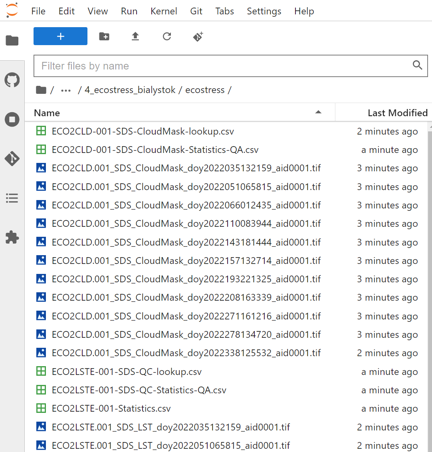

In [69]:
image = Image.open('ecostress_files.png')
display(image.resize((int(image.width * 0.4), int(image.height * 0.4))))

Each timestamp and data type is saved to a separate file with an appropriate file extension. Let's have a quick look at one of the temperature images. As it has a geographic reference, we can plot it using the Rasterio package:

In [70]:
temp_path = 'ecostress/ECO2LSTE.001_SDS_LST_doy2022157132714_aid0001.tif'

In [71]:
src = rasterio.open(temp_path)

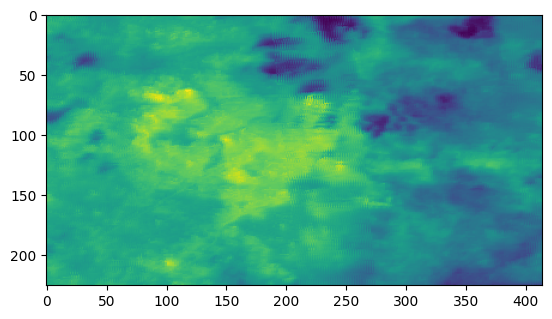

In [72]:
pyplot.imshow(src.read(1));

### Step 4: transforming the data to a common coordinate system

At this stage of processing, our data are not in the same coordinate system. The GeoJSON file defining the spatial extent is in WGS 84 (EPSG: 4326), similarly to ECOSTRESS images (as we chose the "projection" variable to be "native" in the request). Sentinel-2 image is on the other hand in UTM zone 34N (EPSG: 32634). As our goal is to create a map, the next step of our work is to reproject the GeoJSON polygon and ECOSTRESS rasters to the UTM 34N coordinate system.

In [74]:
polygon = gpd.read_file(area_path)

In [75]:
polygon_reprojected = polygon.to_crs("EPSG:32634")

In [76]:
polygon_reprojected.to_file("map_reprojected.geojson", driver='GeoJSON')

In order to perform the reprojection for ECOSTRESS data we first need to filter out the paths to .tif files - LST and cloud masks. We can omit the quality (QC) rasters for now. 

In [77]:
lst_paths = glob.glob("ecostress/*_LST_*")

In [78]:
lst_paths

['ecostress/ECO2LSTE.001_SDS_LST_doy2022278134720_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022110083944_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022157132714_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022051065815_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022338125532_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022208163339_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022271161216_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022193221325_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022066012435_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022035132159_aid0001.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022143181444_aid0001.tif']

In [79]:
cloudmask_paths = glob.glob("ecostress/*_CloudMask_*")

In [80]:
cloudmask_paths

['ecostress/ECO2CLD.001_SDS_CloudMask_doy2022066012435_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022193221325_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022157132714_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022208163339_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022143181444_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022338125532_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022035132159_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022278134720_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022051065815_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022110083944_aid0001.tif',
 'ecostress/ECO2CLD.001_SDS_CloudMask_doy2022271161216_aid0001.tif']

Having the paths prepared, we can run the `reproject_raster` function for each of them. We should also notice that LST images are connected with their cloud masks by their Day Of Year (DOY) timestamp.

In [81]:
# function created based on: https://rasterio.readthedocs.io/en/latest/topics/reproject.html
def reproject_raster(input_path, dst_crs):
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(input_path[:-4] + "_reprojected.tif", 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [82]:
for lst_raster in lst_paths:
    reproject_raster(lst_raster, dst_crs='EPSG:32634')

In [83]:
for cm_raster in cloudmask_paths:
    reproject_raster(cm_raster, dst_crs='EPSG:32634')

### Step 5: stacking and clipping the data to a common spatial extent

As we saw above, the ECOSTRESS data obtained from the server response file were already clipped to the spatial extent of the research area. The Sentinel-2 image on the contrary, is still in a form of a whole granule. Additionally, each band is currently a separate JPEG2000 raster file. 
In this step, we will therefore firstly stack all necessary S-2 spectral bands together. The future map will include the natural color and false color composites, so we should choose the following bands: 2 (Blue), 3 (Green), 4 (Red) and 8 (NIR). Then, we need to clip the resultant multi-band raster to the research area's extent.

In [84]:
stack_paths = []

In [85]:
for b in [2, 3, 4, 8]:
    stack_paths.append(glob.glob('s2/**/IMG_DATA/*B0' + str(b) + '.jp2', recursive = True)[0])

In [86]:
stack_paths

['s2/S2B_MSIL1C_20220504T094029_N0400_R036_T34UFD_20220504T114559.SAFE/GRANULE/L1C_T34UFD_A026946_20220504T094026/IMG_DATA/T34UFD_20220504T094029_B02.jp2',
 's2/S2B_MSIL1C_20220504T094029_N0400_R036_T34UFD_20220504T114559.SAFE/GRANULE/L1C_T34UFD_A026946_20220504T094026/IMG_DATA/T34UFD_20220504T094029_B03.jp2',
 's2/S2B_MSIL1C_20220504T094029_N0400_R036_T34UFD_20220504T114559.SAFE/GRANULE/L1C_T34UFD_A026946_20220504T094026/IMG_DATA/T34UFD_20220504T094029_B04.jp2',
 's2/S2B_MSIL1C_20220504T094029_N0400_R036_T34UFD_20220504T114559.SAFE/GRANULE/L1C_T34UFD_A026946_20220504T094026/IMG_DATA/T34UFD_20220504T094029_B08.jp2']

In [87]:
# function created based on: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands 
def stack_bands(input_paths):
    # Read metadata of first file
    with rasterio.open(input_paths[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(input_paths))
    # Update meta driver to the stack's one
    meta.update(driver = 'GTiff')
    
    # Read each layer and write it to stack
    with rasterio.open('stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(input_paths, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

In [88]:
stack_bands(input_paths = stack_paths)

When the stack is ready we can proceed with the clipping part:

In [89]:
def clip_raster_by_vector(input_raster, input_vector):
    import fiona
    import rasterio
    import rasterio.mask
    
    with fiona.open(input_vector, "r") as v:
        shapes = [feature["geometry"] for feature in v]
    with rasterio.open(input_raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    with rasterio.open(input_raster[:-4] + "_clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [90]:
clip_raster_by_vector(input_raster = "stack.tif", input_vector = 'map_reprojected.geojson')

Finally, we can view the result of stacking and clipping below:

In [91]:
dataset_s2 = rasterio.open('stack_clipped.tif')
array_s2 = dataset_s2.read()

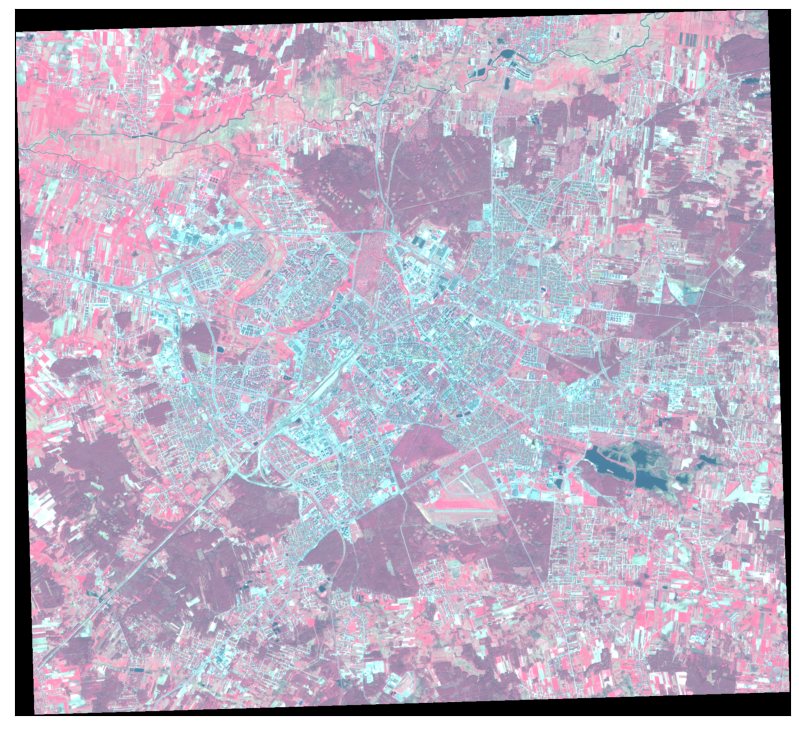

In [93]:
ep.plot_rgb(array_s2, rgb=(3, 2, 1), stretch=True, str_clip=5);

### Step 6: calculating the surface temperature

The temperature images we currently have still need to be rescaled to Celsius degrees for proper presentation. We will start by filtering out the LST reprojected raster files. Then we will rescale their values and save as new files.

In [94]:
lst_reprojected_paths = glob.glob("ecostress/*LST*reprojected*")

In [95]:
lst_reprojected_paths

['ecostress/ECO2LSTE.001_SDS_LST_doy2022035132159_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022271161216_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022051065815_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022338125532_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022066012435_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022157132714_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022208163339_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022143181444_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022278134720_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022110083944_aid0001_reprojected.tif',
 'ecostress/ECO2LSTE.001_SDS_LST_doy2022193221325_aid0001_reprojected.tif']

In [96]:
def temperature_raster(input_raster):
    import rasterio
    dataset = rasterio.open(input_raster)
    array = dataset.read(1).astype(float)
    array_temp = (array * 0.02) - 273.15
    array_temp_reshaped = array_temp.reshape((1, array_temp.shape[0], array_temp.shape[1]))
    outmeta = dataset.meta
    outmeta["dtype"] = "float32"
    outmeta["nodata"] = -273.15
    with rasterio.open(input_raster[:-4] + "_temp.tif", "w", **outmeta) as dest:
        dest.write(array_temp_reshaped)

In [97]:
for lst_raster in lst_reprojected_paths:
    temperature_raster(lst_raster)

### Step 7: familiarizing with the LST statistics

One of the last steps before creating a gif out of the gathered data will be to have a look at the temperature statistics provided as a supplementary file to the temperature rasters. As we will see, each row is characterizing one timestamp. 

In [98]:
stats_path = "ecostress/ECO2LSTE-001-Statistics.csv"

In [99]:
stats_df = pd.read_csv(stats_path)

In [100]:
stats_df.head()

,File Name,Dataset,aid,Date,Orbit Number,Scene ID,Build ID,Orbit Correction Performed,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
0,ECO2LSTE_001_SDS_LST_doy2022035132159_aid0001,SDS_LST,aid0001,2022-02-04 13:21:59 UTC,20316,8,601,False,93564.0,258.04,270.34,"(258.04,270.34)",263.203344,2.131478,4.543198,264.62,269.12,262.86,258.04,261.62
1,ECO2LSTE_001_SDS_LST_doy2022051065815_aid0001,SDS_LST,aid0001,2022-02-20 06:58:15 UTC,20560,7,601,False,93150.0,246.04,265.66,"(246.04,265.66)",252.721752,2.995081,8.970511,254.52,260.54,252.04,246.04,250.50
2,ECO2LSTE_001_SDS_LST_doy2022066012435_aid0001,SDS_LST,aid0001,2022-03-07 01:24:35 UTC,20789,9,601,True,93564.0,257.06,262.00,"(257.06,262.0)",258.994320,0.608610,0.370406,259.40,260.66,258.96,257.30,258.56
3,ECO2LSTE_001_SDS_LST_doy2022110083944_aid0001,SDS_LST,aid0001,2022-04-20 08:39:44 UTC,21477,9,601,True,93790.0,228.90,260.36,"(228.9,260.36)",252.077594,5.632796,31.728389,255.54,260.36,253.74,245.04,251.34
4,ECO2LSTE_001_SDS_LST_doy2022143181444_aid0001,SDS_LST,aid0001,2022-05-23 18:14:44 UTC,21996,8,601,True,93564.0,277.96,290.74,"(277.96,290.74)",284.444600,1.731799,2.999126,285.54,288.80,284.46,280.10,283.36


The provided statistics could potentially be used for some further analyses. We will not need them however, and therefore we can limit the file to two useful columns: 

In [101]:
stats_df = stats_df.loc[stats_df["Dataset"] == "SDS_LST", ["File Name", "Date"]]

In [102]:
stats_df

,File Name,Date
0,ECO2LSTE_001_SDS_LST_doy2022035132159_aid0001,2022-02-04 13:21:59 UTC
1,ECO2LSTE_001_SDS_LST_doy2022051065815_aid0001,2022-02-20 06:58:15 UTC
2,ECO2LSTE_001_SDS_LST_doy2022066012435_aid0001,2022-03-07 01:24:35 UTC
3,ECO2LSTE_001_SDS_LST_doy2022110083944_aid0001,2022-04-20 08:39:44 UTC
4,ECO2LSTE_001_SDS_LST_doy2022143181444_aid0001,2022-05-23 18:14:44 UTC
5,ECO2LSTE_001_SDS_LST_doy2022157132714_aid0001,2022-06-06 13:27:14 UTC
6,ECO2LSTE_001_SDS_LST_doy2022193221325_aid0001,2022-07-12 22:13:25 UTC
7,ECO2LSTE_001_SDS_LST_doy2022208163339_aid0001,2022-07-27 16:33:39 UTC
8,ECO2LSTE_001_SDS_LST_doy2022271161216_aid0001,2022-09-28 16:12:16 UTC
9,ECO2LSTE_001_SDS_LST_doy2022278134720_aid0001,2022-10-05 13:47:20 UTC


By using the DOY identifier, we will now extend the Data Frame by joining additional information calculated from the respective cloud masks. In order to know how to interpret the cloud raster, we should have a look at the CloudMask lookup file: 

In [103]:
clookup_path = "ecostress/ECO2CLD-001-SDS-CloudMask-lookup.csv"

In [104]:
clookup_df = pd.read_csv(clookup_path)

In [105]:
clookup_df

,Value,Cloud Mask Flag,Final Cloud Plus Region-growing,"Final Cloud, either one of bits 2, 3 ,or 4 set",band 4 Brightness Threshold Test,Band 4-5 Thermal Difference test,Land/Water Mask
0,0,not determined,no,no,no,no,land
1,1,determined,no,no,no,no,land
2,2,not determined,yes,no,no,no,land
3,3,determined,yes,no,no,no,land
4,14,not determined,yes,yes,yes,no,land
5,15,determined,yes,yes,yes,no,land
6,23,determined,yes,yes,no,yes,land
7,31,determined,yes,yes,yes,yes,land
8,33,determined,no,no,no,no,water
9,35,determined,yes,no,no,no,water


The provided information let us conclude that cloudy and non-cloudy pixel values are:  

In [106]:
cloudy_values = [15, 23, 31, 47, 55, 63]
non_cloudy_values = [1, 3, 33, 35]

In [107]:
for index, row in stats_df.iterrows():
    
    # find the lst image
    lst_image = glob.glob("**/*" + row["File Name"].split("_")[-2] + "*reprojected_temp.tif", recursive=True)[0]
    # find the related cloud image 
    cloud_image = glob.glob("**/*CloudMask*" + row["File Name"].split("_")[-2] + "*reprojected.tif", recursive=True)[0]
    
    # calculate the percentage of clouds
    dataset = rasterio.open(cloud_image)
    array = dataset.read(1).flatten()
    array_subset = array[(array==1) ^ (array==3) ^ (array==33) ^ (array==35)]
    perc = 100 - round(array_subset.shape[0]/array.shape[0]*100, 2)
    stats_df.loc[index, "cloud_perc"] = perc

In [108]:
stats_df

,File Name,Date,cloud_perc
0,ECO2LSTE_001_SDS_LST_doy2022035132159_aid0001,2022-02-04 13:21:59 UTC,100.00
1,ECO2LSTE_001_SDS_LST_doy2022051065815_aid0001,2022-02-20 06:58:15 UTC,100.00
2,ECO2LSTE_001_SDS_LST_doy2022066012435_aid0001,2022-03-07 01:24:35 UTC,100.00
3,ECO2LSTE_001_SDS_LST_doy2022110083944_aid0001,2022-04-20 08:39:44 UTC,100.00
4,ECO2LSTE_001_SDS_LST_doy2022143181444_aid0001,2022-05-23 18:14:44 UTC,7.23
5,ECO2LSTE_001_SDS_LST_doy2022157132714_aid0001,2022-06-06 13:27:14 UTC,42.29
6,ECO2LSTE_001_SDS_LST_doy2022193221325_aid0001,2022-07-12 22:13:25 UTC,100.00
7,ECO2LSTE_001_SDS_LST_doy2022208163339_aid0001,2022-07-27 16:33:39 UTC,14.46
8,ECO2LSTE_001_SDS_LST_doy2022271161216_aid0001,2022-09-28 16:12:16 UTC,16.55
9,ECO2LSTE_001_SDS_LST_doy2022278134720_aid0001,2022-10-05 13:47:20 UTC,100.00


The number of images available for a particalar location in not uniform and seems to be the result of NASA's acquisition strategy. I also studied two other Polish cities - Warsaw (central Poland) and Cracow (south Poland) - both had a few times more images. One needs to check the data availability for his/her city of choice.  

Images with less than 20% of cloud coverage seem to be useful for observing the temperature patterns. We can therefore get rid off the more cloudy ones:

In [109]:
stats_df = stats_df.loc[stats_df["cloud_perc"] < 20, :]

In [110]:
stats_df

,File Name,Date,cloud_perc
4,ECO2LSTE_001_SDS_LST_doy2022143181444_aid0001,2022-05-23 18:14:44 UTC,7.23
7,ECO2LSTE_001_SDS_LST_doy2022208163339_aid0001,2022-07-27 16:33:39 UTC,14.46
8,ECO2LSTE_001_SDS_LST_doy2022271161216_aid0001,2022-09-28 16:12:16 UTC,16.55


In [111]:
stats_df.to_csv('stats.csv')

### Step 8: converting cloud raster masks into polygon features

So far, cloud masks let us filter out the most cloudy temperature images, the ones we do not like to view in our future gif. A few of the remaining ones still have however some clouds. It would be helpful for the future viewers to know where exactly the temperature values may be distorted by the presence of clouds. In order to present them conveniently in the gif, we firstly need to convert clod masks to vectors:

In [112]:
cloudmask_reprojected_paths = glob.glob("ecostress/*CloudMask*reprojected.tif")

In [113]:
def clouds_vector(input_clouds_raster, cloud_values):
    # importing packages
    import os
    import rasterio
    from rasterio.features import shapes
    from shapely.geometry import shape
    import geopandas as gpd
    # transforming raster to GeoDataFrame
    with rasterio.open(input_clouds_raster) as src:
        image = src.read(1) 
        results = ({'properties': {'raster_val': v}, 'geometry': s} for i, (s, v) in enumerate(shapes(image, transform=src.transform)))
    geoms = list(results)
    geoms_gdf = gpd.GeoDataFrame.from_features(geoms)
    # selecting polygons of clouds
    geoms_gdf = geoms_gdf.loc[geoms_gdf["raster_val"].isin(cloud_values)]
    # saving results to GeoJSON
    if geoms_gdf.shape[0] != 0:
        geoms_gdf.to_file(os.path.join(os.path.dirname(input_clouds_raster), \
                                       "cloud_vector_" + os.path.basename(input_clouds_raster).split("_")[3]+".geojson"), driver="GeoJSON")  

In [114]:
for cm in cloudmask_reprojected_paths:
    clouds_vector(input_clouds_raster = cm, cloud_values = cloudy_values)

### Step 9. creating an animated gif

Finally, we have all the input data ready for creating an animated gif file. Each presented timestamp map will be produced by iterating the rows of our statistics' Data Frame. Each row is equipped with a DOY identifier which enables the algorithm to find the appropriate geodata to present: 

In [115]:
# importing additional packages
import os
import glob
import rasterio
import pandas as pd
import geopandas as gpd
import earthpy.plot as ep
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Polygon, Patch
from PIL import Image, ImageDraw

In [116]:
# preparing map elements
dataset_s2 = rasterio.open('stack_clipped.tif')
array_s2 = dataset_s2.read()
raster_profile = dataset_s2.profile
vector_extent = plotting_extent(array_s2[0], raster_profile["transform"])

The acquisition date of the Sentinel-2 image can be found out either by extracting it from the name of a band raster (approach presented below) or by searching through metadata .xml file. 

In [117]:
# checking the S-2 acquisition date
s2_date_pre = os.path.basename(glob.glob('s2/**/IMG_DATA/*B01.jp2', recursive = True)[0]).split('_')[1][:8]
s2_date = s2_date_pre[:4] + "-" + s2_date_pre[4:6] + "-" + s2_date_pre[6:]

We can make our future gif easier to interpret by adding a polygon layer with some important topological objects. I will add the city's boundary as an example: 

In [118]:
object_gdf = gpd.read_file('object.geojson')

In [131]:
# gif list 
gif_list = []

In [120]:
# new directory for maps
os.mkdir('maps')

In [121]:
# looping through temp images
stats_df = pd.read_csv('stats.csv')

In [132]:
for index, row in stats_df.iterrows():
    lst = glob.glob("ecostress/*"+row["File Name"].split("_")[-2]+"*reprojected_temp*")[0]
    dataset_lst = rasterio.open(lst)
    
    lst_time = str(row["Date"]) 
                   
    clouds = glob.glob("ecostress/cloud_vector*"+row["File Name"].split("_")[-2]+"*")
    if len(clouds) != 0:
        clouds_gdf = gpd.read_file(clouds[0])
    # map
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22,6), gridspec_kw = {'wspace':0, 'hspace':0})

    #ax1
    object_gdf.boundary.plot(aspect=1, ax=ax1, color="black", linewidth=2, linestyle="dashed")
    ax1.legend(labels = ["object"], handles=[Patch(edgecolor='black', facecolor="lightgrey", linestyle="dashed")])
    ep.plot_rgb(array_s2, rgb=(2, 1, 0), ax=ax1, stretch=True, str_clip=6, extent=vector_extent)
    ax1.set_title("Sentinel-2 RGB 432 \n " + s2_date)

    #ax2
    object_gdf.boundary.plot(aspect=1, ax=ax2, color="black", linewidth=2, linestyle="dashed")
    ax2.legend(labels = ["object"], handles=[Patch(edgecolor='black', facecolor="lightgrey", linestyle="dashed")])
    ep.plot_rgb(array_s2, rgb=(3, 2, 1), ax=ax2, stretch=True, str_clip=6, extent=vector_extent)
    ax2.set_title("Sentinel-2 RGB 843 \n " + s2_date)

    #ax3 
    object_gdf.boundary.plot(aspect=1, ax=ax3, color="black", linewidth=2, linestyle="dashed")
    if len(clouds) != 0:
        clouds_gdf.plot(aspect=1, ax=ax3, color = "lightgrey", legend=True, alpha=0.4, hatch='..')
    ax3.legend(labels = ["object", "clouds"], handles=[Patch(edgecolor='black', facecolor="lightgrey", linestyle="dashed"), Patch(facecolor='lightgrey', hatch='...')])
    im3 = ax3.imshow(dataset_lst.read(1), cmap='RdBu_r', vmin=0, vmax=30, extent=vector_extent)
    divider_ax3 = make_axes_locatable(ax3)
    cax3 = divider_ax3.append_axes("right", size="5%", pad=0.2)

    cbar = plt.colorbar(im3, cax = cax3)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('degrees Celsius', rotation=270)

    ax3.set_title("ECOSTRESS Surface Temperature \n " + lst_time)

    ax3.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

    plt.savefig(os.path.join('maps', "map_" + str(index) + "_" + row["File Name"].split("_")[-2] + ".png"), dpi=300, \
               facecolor='white', transparent=False, bbox_inches = 'tight')
    gif_list.append(Image.open(os.path.join('maps', "map_" + str(index) + "_" + row["File Name"].split("_")[-2] + ".png")))
    
    pyplot.close(fig)

In [134]:
# gif creation
gif_list[0].save(os.path.join('maps', "my_gif.gif"), save_all = True, append_images = gif_list[1:], optimize = False, duration = 3000)

## 🎉🎉🎉 Here is our final gif:

In [135]:
from IPython import display
display.HTML('<img src="maps/my_gif.gif">')

We can observe clear temperature patterns related, among other, to land cover types - artificial surfaces and water bodies. 

Additional tips:
- it is suggested to manipulate the parameters used above i.a. figsize (to fit the shape of the chosen research area), colormap and the range of values presented 
- some of the temperature images may by affected by striping (to read more about the problem, please have a look at NASA JPL's report: https://ecostress.jpl.nasa.gov/downloads/20181017_ECOSTRESS_data_description-Frequently_Asked_Questions.pdf )